In [55]:
import torch
import torchvision.models as models
from torchvision import transforms
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets, models
from torchvision.models import vgg11
from sklearn.metrics import precision_score, recall_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [36]:
data1_path = "/content/drive/MyDrive/Dataset_Project/Data1/Dataset 1/Colorectal Cancer "

In [37]:
transform = transforms.Compose([
    transforms.Resize((224, 224)), transforms.ToTensor(),transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

dataset1 = datasets.ImageFolder(data1_path, transform=transform)

train_size = int(0.8 * len(dataset1))
val_size = int(0.1 * len(dataset1))
test_size = len(dataset1) - train_size - val_size
train_set, val_set, test_set = random_split(dataset1, [train_size, val_size, test_size])

In [38]:
model = vgg11(weights='DEFAULT')

for param in model.features[:-5].parameters():
    param.requires_grad = False

num_classes = 3
model.classifier[6] = nn.Linear(4096, num_classes)

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [40]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32)
test_loader = DataLoader(test_set, batch_size=32)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

best_val_loss = float("inf")
patience = 5
no_improvement_count = 0

num_epochs = 50
for epoch in range(num_epochs):
    print('start epoch ', epoch)
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch + 1}/{num_epochs} - Loss: {running_loss / len(train_loader)}")

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

        val_loss /= len(val_loader)

    print(f'Validation Loss: {val_loss}')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improvement_count = 0
    else:
        no_improvement_count += 1

    if no_improvement_count >= patience:
        print(f'Early stopping after {epoch + 1} epochs with no improvement.')
        break

print('Training finished.')
print('Testing begin.')
model.eval()
correct = 0
total = 0
test_loss = 0.0

all_labels = []
all_predicted = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)

        all_predicted.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
avg_test_loss = test_loss / len(test_loader)
precision = precision_score(all_labels, all_predicted, average='weighted')
recall = recall_score(all_labels, all_predicted, average='weighted')



print(f'Test Accuracy: {accuracy}%')
print(f'Test Loss: {avg_test_loss}')
print('Test Precision', precision)
print('Test recall', recall)

start epoch  0
Epoch 1/50 - Loss: 0.3550677024324735
Validation Loss: 0.17940331642564974
start epoch  1
Epoch 2/50 - Loss: 0.15686749489357074
Validation Loss: 0.11879479100829676
start epoch  2
Epoch 3/50 - Loss: 0.10322788360528648
Validation Loss: 0.08888861223271019
start epoch  3
Epoch 4/50 - Loss: 0.07415777519966166
Validation Loss: 0.08218485509094439
start epoch  4
Epoch 5/50 - Loss: 0.048651062742962194
Validation Loss: 0.08058248048550204
start epoch  5
Epoch 6/50 - Loss: 0.03661341044663762
Validation Loss: 0.10366469322654762
start epoch  6
Epoch 7/50 - Loss: 0.02475392702501267
Validation Loss: 0.058969023171812296
start epoch  7
Epoch 8/50 - Loss: 0.021950872104304534
Validation Loss: 0.06583881539929855
start epoch  8
Epoch 9/50 - Loss: 0.012316098239680287
Validation Loss: 0.057566610213957335
start epoch  9
Epoch 10/50 - Loss: 0.009450766568334075
Validation Loss: 0.06789626057357773
start epoch  10
Epoch 11/50 - Loss: 0.006585511064816577
Validation Loss: 0.08177435

Removing the classification layer from model 1 of task 1, and extract features:


In [41]:
model.classifier = nn.Identity()
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [56]:
def extract_features(model, dataloader):
    model.eval()
    features = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            features.append(outputs)

    features = torch.cat(features)
    return features

Model 1 of Task 1 on Dataset 2

In [57]:
data2_path = "/content/drive/MyDrive/Dataset_Project/Data2/Dataset 2/Prostate Cancer"

dataset2 = datasets.ImageFolder(data2_path, transform=transform)

dataloader2 = DataLoader(dataset2, batch_size=32)

features2 = extract_features(model, dataloader2)

In [58]:
all_features = []
all_labels = []

with torch.no_grad():
    for images, labels in dataloader2:
        images, labels = images.to(device), labels.to(device)
        outputs = model.features(images)
        outputs = model.avgpool(outputs)
        outputs = torch.flatten(outputs, 1)
        all_features.append(outputs)
        all_labels.append(labels)
all_features = torch.cat(all_features, dim=0).cpu().numpy()
all_labels = torch.cat(all_labels, dim=0).cpu().numpy()
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(all_features)

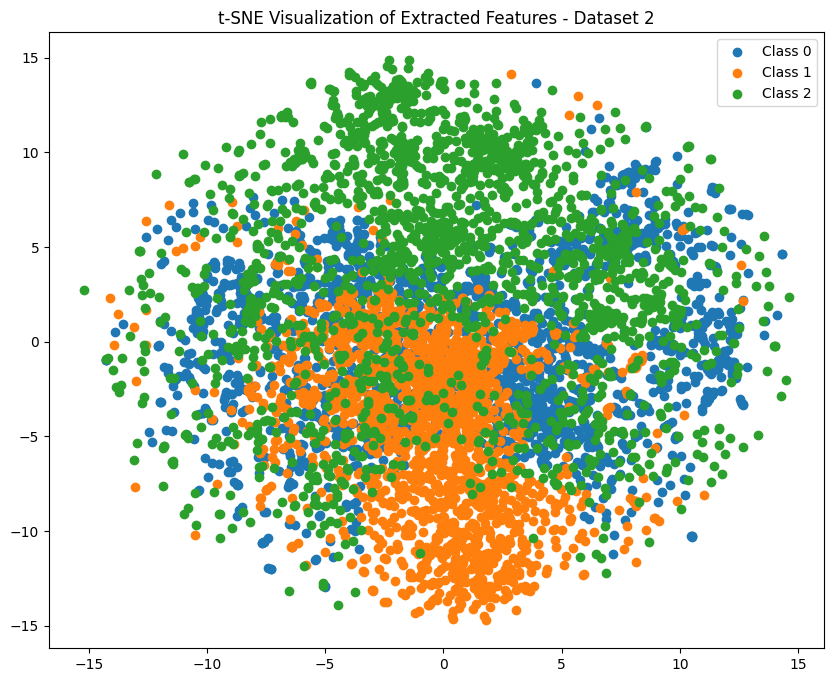

In [59]:
plt.figure(figsize=(10, 8))
for i in range(len(dataset2.classes)):
    plt.scatter(tsne_result[all_labels == i, 0], tsne_result[all_labels == i, 1], label=f'Class {i}')

plt.title('t-SNE Visualization of Extracted Features - Dataset 2')
plt.legend()
plt.show()

Model1 of task 1 on Dataset3

In [60]:
data3_path = "/content/drive/MyDrive/Dataset_Project/Data3/Dataset 3/Animal Faces"

dataset3 = datasets.ImageFolder(data3_path, transform=transform)

dataloader3 = DataLoader(dataset3, batch_size=32)

features3 = extract_features(model, dataloader3)

In [62]:
all_features2 = []
all_labels2 = []

with torch.no_grad():
    for images, labels in dataloader3:
        images, labels = images.to(device), labels.to(device)
        outputs = model.features(images)
        outputs = model.avgpool(outputs)
        outputs = torch.flatten(outputs, 1)
        all_features2.append(outputs)
        all_labels2.append(labels)
all_features2 = torch.cat(all_features2, dim=0).cpu().numpy()
all_labels2 = torch.cat(all_labels2, dim=0).cpu().numpy()
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(all_features2)

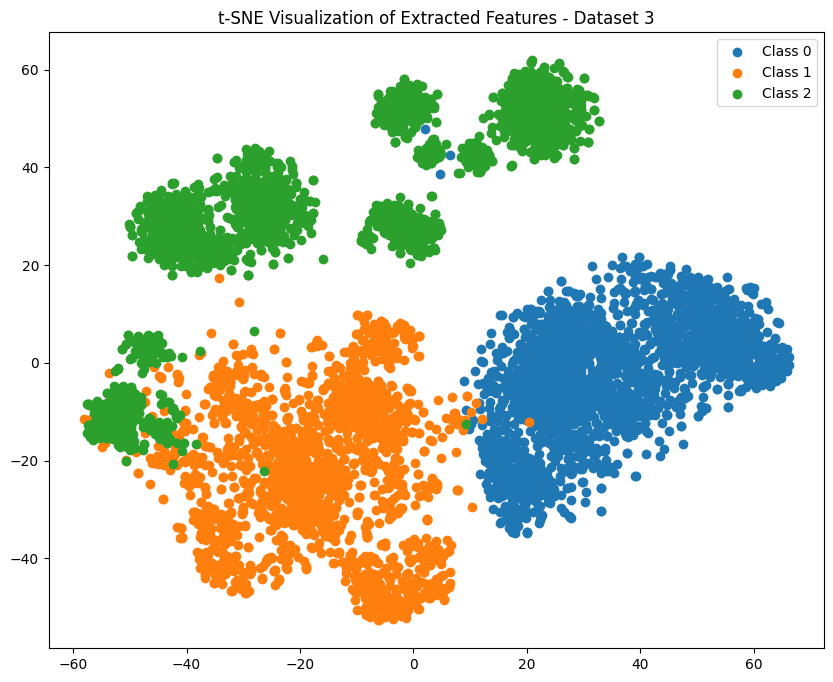

In [63]:
plt.figure(figsize=(10, 8))
for i in range(len(dataset3.classes)):
    plt.scatter(tsne_result[all_labels2 == i, 0], tsne_result[all_labels2 == i, 1], label=f'Class {i}')

plt.title('t-SNE Visualization of Extracted Features - Dataset 3')
plt.legend()
plt.show()